In [1]:
import sys, os
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
from matplotlib import pyplot as plt


train = pd.read_csv(os.path.join("data", "train.csv"))  
test = pd.read_csv(os.path.join("data", "test.csv"))

data_no_id = train.drop(["id"], axis=1)
dataX = train.drop(["id", 'formation_energy_ev_natom', 'bandgap_energy_ev'], axis=1)

In [2]:
### Definitions
def RMSLE(pred1,pred2,true1,true2):
    """
    Root mean squared logarithmic error:
    - pred1: 
    - pred2:
    - true1:

    """
    pred1 = np.array(pred1)
    pred2 = np.array(pred2)
    true1 = np.array(true1)
    true2 = np.array(true2)
    error1 = np.square(np.log(pred1 + 1) - np.log(true1 + 1)).mean()**0.5
    error2 = np.square(np.log(pred2 + 1) - np.log(true2 + 1)).mean()**0.5
    return np.sum(error1 + error2)/2


### Dataset visualization

In [3]:
print("===== Training dataset =====")
print("Shape: ",train.shape)
train.head(6)

===== Training dataset =====
Shape:  (2400, 14)


,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,formation_energy_ev_natom,bandgap_energy_ev
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793
5,6,227,40.0,0.5625,0.4375,0.000,9.8456,5.7176,14.1244,91.1235,91.3033,30.5730,0.2209,2.1633


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          2400 non-null   int64  
 1   spacegroup                  2400 non-null   int64  
 2   number_of_total_atoms       2400 non-null   float64
 3   percent_atom_al             2400 non-null   float64
 4   percent_atom_ga             2400 non-null   float64
 5   percent_atom_in             2400 non-null   float64
 6   lattice_vector_1_ang        2400 non-null   float64
 7   lattice_vector_2_ang        2400 non-null   float64
 8   lattice_vector_3_ang        2400 non-null   float64
 9   lattice_angle_alpha_degree  2400 non-null   float64
 10  lattice_angle_beta_degree   2400 non-null   float64
 11  lattice_angle_gamma_degree  2400 non-null   float64
 12  formation_energy_ev_natom   2400 non-null   float64
 13  bandgap_energy_ev           2400 

In [5]:
xyz_dummy = pd.read_table(os.path.join("data", "train", "1", "geometry.xyz"))
xyz_dummy.head(8)

,#=======================================================
0,#Created using the Atomic Simulation Environme...
1,#=============================================...
2,lattice_vector 9.9520877199999997 -0.047248240...
3,lattice_vector 0.0403159900000000 8.5511748500...
4,lattice_vector 0.0316403800000000 0.0096659200...
5,atom 1.6088879366700000 7.2764162181499996 6.3...
6,atom 6.5849317966699994 7.2527920981499996 6.3...
7,atom 3.4357584130499994 1.2597758443300000 1.7...


The training dataset consists of 2400 observations for 13 features each. Out of 13 features, 2 of these are categorical, while the rest are numerical. The features mostly show information about the unit cell of the given compound:
- 4 composition features: The **percent_atom** for "Al", "Ga" and "In" describe the relative composition of the material between the three elements. Each of these features range from 0 to 1. The **number_of_total_atoms** feature indicates the total number of atoms inside the unit cell and ranges from 10 to 80.
- Other training features describe the geometry of the unit cell, which is the fundamental building block of the material:
    - The **spacegroup** column explains the symmetry of the grid
    - The **lattice_vector** and **lattice_angle** features describe the spatial dimensions and distortions of the grid.
- **formation_energy_ev_atom** and **bandgap_energy_ev** are the target variables. They are floating point features measuring energies in the unit of the electron-volt (eV).

 Each measurement represents a compound, which is also associated to a separate file (geometry.xyz) containing coordinates for all atoms inside the unit cell. The table in the **geometry.xyz** file encodes the positions of all atoms, therefore it is Nx3 in size, where N is the total number of atoms in the compound.

### Data visualization
A good way to start handling data is to visualize it, in order to extract useful information and initial prediction for data patterns.

Formation energy mean: 0.188 +- 0.104 eV
Bandgap energy mean: 2.077 +- 1.007 eV 



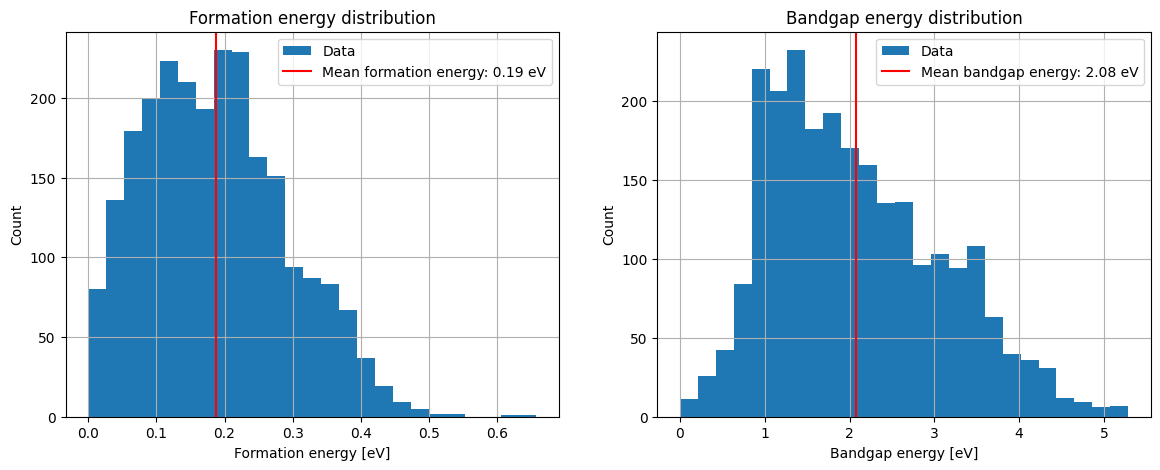

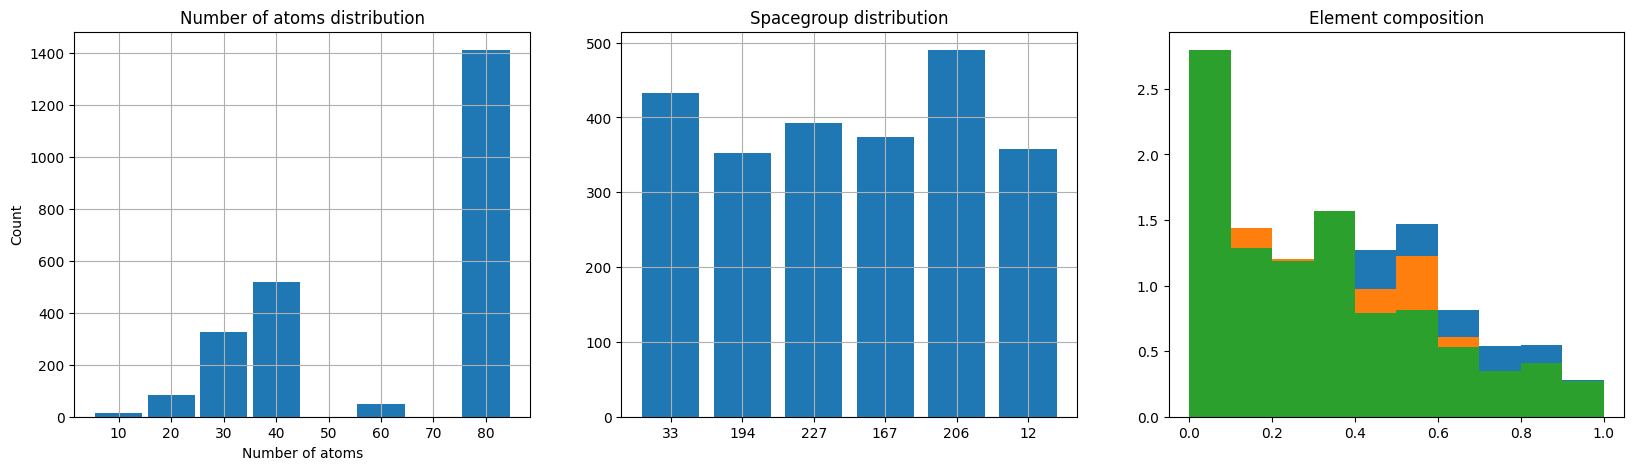

In [6]:
from collections import Counter

formation_energy = train['formation_energy_ev_natom']
bandgap_energy = train['bandgap_energy_ev']
mean_formation_energy = np.mean(formation_energy)
mean_bandgap_energy = np.mean(bandgap_energy)
std_formation_energy = np.std(formation_energy)
std_bandgap_energy = np.std(bandgap_energy)
print(f"Formation energy mean: {mean_formation_energy:.3f} +- {std_formation_energy:.3f} eV")
print(f"Bandgap energy mean: {mean_bandgap_energy:.3f} +- {std_bandgap_energy:.3f} eV", "\n")

### Energy distributions
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].hist(formation_energy, bins=25, label="Data")
ax[0].axvline(x=mean_formation_energy, color="red", label=f"Mean formation energy: {mean_formation_energy:.2f} eV")
ax[0].set_title("Formation energy distribution")
ax[0].set_xlabel("Formation energy [eV]")
ax[0].set_ylabel("Count")
ax[0].grid(True)
ax[0].legend()

ax[1].hist(bandgap_energy, bins=25, label="Data")
ax[1].axvline(x=mean_bandgap_energy, color="red", label=f"Mean bandgap energy: {mean_bandgap_energy:.2f} eV")
ax[1].set_title("Bandgap energy distribution")
ax[1].set_xlabel("Bandgap energy [eV]")
ax[1].set_ylabel("Count")
ax[1].grid(True)
ax[1].legend()
plt.show()

### Feature representation
# Number of atoms
fig, ax = plt.subplots(1, 3, figsize=(20,5))
n_total_atoms_dict = dict(Counter(train['number_of_total_atoms']))
ax[0].bar(n_total_atoms_dict.keys(), n_total_atoms_dict.values(), width=9)
ax[0].set_title("Number of atoms distribution")
ax[0].set_xlabel("Number of atoms")
ax[0].set_ylabel("Count")
ax[0].grid(True)

# Spacegroups
spacegroup_dict = dict(Counter(train['spacegroup']))
ax[1].bar([i for i in range(0, len(spacegroup_dict))], spacegroup_dict.values())
ax[1].set_xticks([i for i in range(0, len(spacegroup_dict))], [str(i) for i in list(spacegroup_dict)])
ax[1].set_title("Spacegroup distribution")
ax[1].grid(True)
#ax[1].set_xticklabels([str(i) for i in list(spacegroup_dict.keys())])

# Composition
ax[2].hist(train['percent_atom_al'], density = True)
ax[2].hist(train['percent_atom_ga'], density = True)
ax[2].hist(train['percent_atom_in'], density = True)
ax[2].set_title("Element composition")


plt.show()

Description


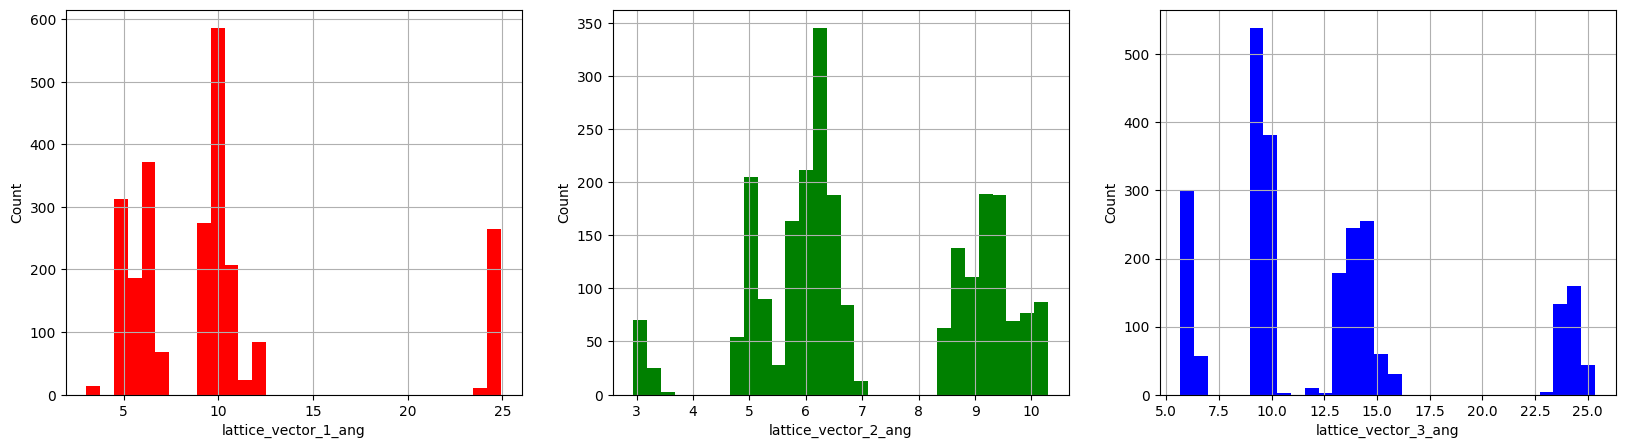

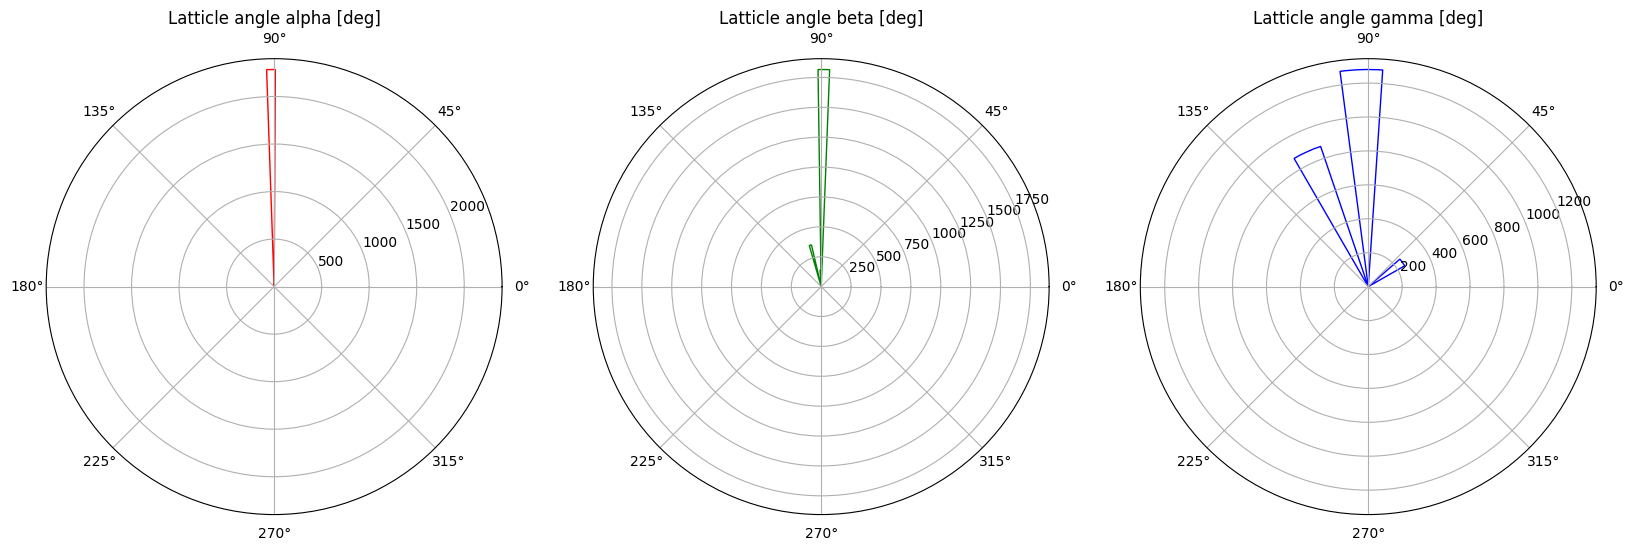

In [7]:


fig, ax = plt.subplots(1,3, figsize=(20,5))
colours = ['r', 'g', 'b']
angles = ['alpha', 'beta', 'gamma']

for i in range(3):
    ax[i].hist(train[f'lattice_vector_{i+1}_ang'], color=colours[i], bins=30)
    ax[i].set_xlabel(f'lattice_vector_{i+1}_ang')
    ax[i].set_ylabel("Count")
    ax[i].grid(True)

fig, ax = plt.subplots(1, 3, figsize=(20,6), subplot_kw=dict(projection='polar'))

for i in range(3):
    ax[i].hist( np.radians(train[f'lattice_angle_{angles[i]}_degree']), color=colours[i], bins=8, fill=False, edgecolor=colours[i])
    ax[i].set_title(f"Latticle angle {angles[i]} [deg]")



# Feature Interactions


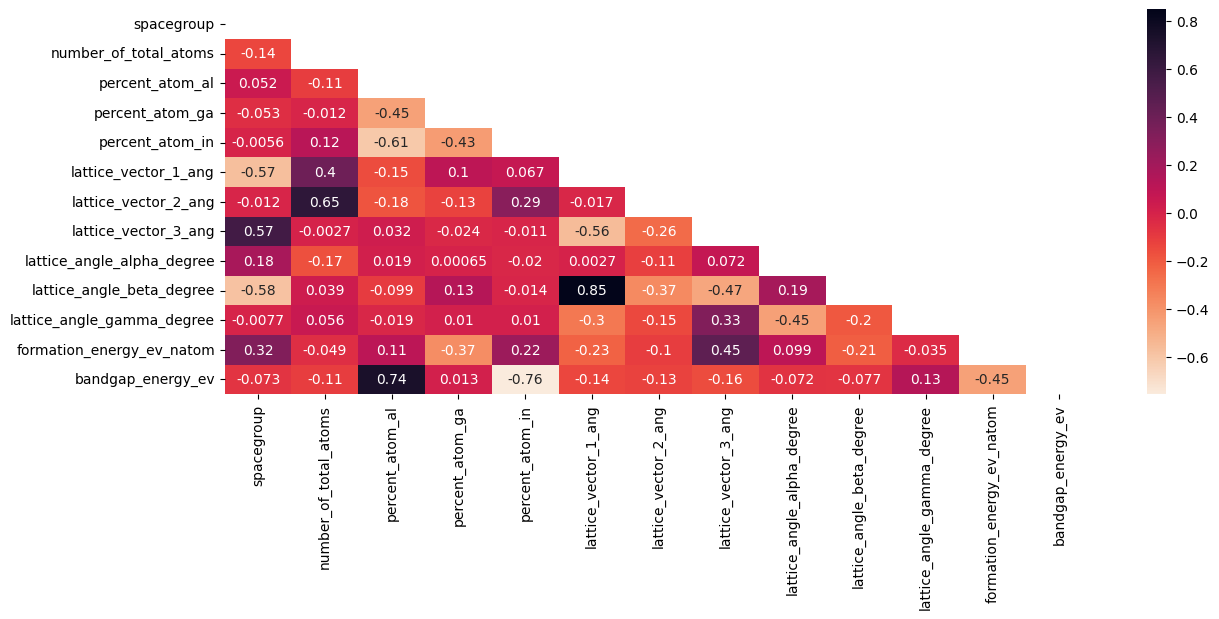

In [8]:
fig, ax = plt.subplots(figsize=(14,5))
corr=data_no_id.corr()
matrix = np.triu(corr)
dataplot = sns.heatmap(corr, cmap="rocket_r", annot=True,mask=matrix) 